# Analytic CCSN Neutrino Emission Models

Two simple classes that implement the solutions to the neutrino radiation transport equation using the diffusion approximation and analytic density solution of the hydrostatic equation of the proto-neutron star (PNS). Taken from Y. Suwa, A. Harada, K. Nakazato, and K. Sumiyoshi, *Analytic solutions for neutrino-light curves of
core-collapse supernovae*, [arXiv:2008.07070](https://arxiv.org/abs/2008.07070), August 2020.

Note the authors' caveats from Section 5 of the paper:
1. Use Lane-Emden solution with $n=1$ for the $\rho$ and $T$ profiles of neutron stars.
1. Assume constant entropy profiles.
1. Use thermal equilibrium (Fermi-Dirac distribution) for neutrino transfer equation.
1. Assume spherical symmetry.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=16)

## Class Definitions

Define two classes implementing the models in Suwa et al. The first builds a neutrino luminosity and average energy model using five free parameters:
1. $M_\mathrm{PNS}$, the protoneutron star mass in units of $M_{\odot}$.
1. $R_\mathrm{PNS}$, the protoneutron star mass in km.
1. $g$, the density correction factor.
1. $\beta$, a scattering boosting factor due to the presence of heavy nuclei.
1. $E_\mathrm{tot}$, the total energy emitted into neutrinos in erg.

The second class is a combination of two analytical models, as described in Section 4 of the paper, to account for the time-dependence of the beta coherent scattering factor.

In [3]:
class CCSNAnalytic:
    """Analytic CCSN neutrino emission model from Y. Suwa, A. Harada, K. Nakazato,
    and K. Sumiyoshi, arXiv:2008.07070, August 2020."""
    
    def __init__(self, M_PNS, R_PNS, g, beta, E_tot):
        """Initialize analytic model parameters.
        
        Parameters
        ----------
        M_PNS : float
            Proto-neutron star mass, in solar masses.
        R_PNS : float
            Proto-neutron star radius, in km.
        g : float
            Density correction factor.
        beta : float
            Opacity boosting factor due to coherent scattering.
        E_tot : float
            Total energy emitted by all flavors of neutrinos, in erg.
        """
        self.M_PNS = M_PNS
        self.R_PNS = R_PNS
        self.g = g
        self.beta = beta
        self.E_tot = E_tot
        
        # Evaluate t0 [s] using eq. 48 of Suwa et al.
        self.t0 = 210 * (self.M_PNS/1.4 * 10/self.R_PNS)**(6/5) \
                      * (self.g*self.beta/3)**(4/5) \
                      * (1e52/self.E_tot)**(1/5)
        
    def Lnu(self, t):
        """Return luminosity vs. time using eq. 47 of Suwa et al.
        
        Parameters
        ----------
        t : float or ndarray
            Time(s) for estimating neutrino luminosity, in s.
        
        Returns
        -------
        Lnu : float or ndarray
            Neutrino luminosity in erg/s.
        """
        return 3.3e51 * (self.M_PNS/1.4 * 10./self.R_PNS)**6 \
                      * (self.g*self.beta/3)**4 \
                      * ((t + self.t0)/100)**-6
    
    def Enu_avg(self, t):
        """Return average neutrino energy using eq. 49 of Suwa et al.
        
        Parameters
        ----------
        t : float or ndarray
            Time(s) for estimating neutrino luminosity, in s.
        
        Returns
        -------
        Enu : float or ndarray
            Average neutrino energy in MeV.
        """
        return 16. * (self.M_PNS/1.4)**(3/2) * (10/self.R_PNS)**2 \
                   * (self.g*self.beta/3) \
                   * ((t + self.t0)/100)**(-3/2)
    
    def __str__(self):
        """Return a readable string representation of the model."""
        return '\n'.join(['M_PNS = {:.2g} M_sun'.format(self.M_PNS),
                          'R_PNS = {:.2g} km'.format(self.R_PNS),
                          'g = {}'.format(self.g),
                          'beta = {}'.format(self.beta),
                          'E_tot = {} erg'.format(self.E_tot)])

    
class CCSNAnalytic2Component:
    """A multi-component model that accounts for the time dependence of the opacity
    boosting factor beta."""
    
    def __init__(self, M_PNS, R_PNS, g, beta1, beta2, E_tot1, E_tot2):
        """Initialize analytic model parameters.
        
        Parameters
        ----------
        M_PNS : float
            Proto-neutron star mass, in solar masses.
        R_PNS : float
            Proto-neutron star radius, in km.
        g : float
            Density correction factor.
        beta1 : float
            Opacity boosting factor of early-time model.
        beta2 : float
            Opacity boosting factor of late-time model.
        E_tot1 : float
            Total energy in neutrinos in early-time model.
        E_tot2 : float
            Total energy in neutrinos in late-time model.
        """
        self.model1 = CCSNAnalytic(M_PNS, R_PNS, g, beta1, E_tot1)
        self.model2 = CCSNAnalytic(M_PNS, R_PNS, g, beta2, E_tot2)
        
    def Lnu(self, t):
        """Return luminosity vs. time as sum of two components in model.
        
        Parameters
        ----------
        t : float or ndarray
            Time(s) for estimating neutrino luminosity, in s.
        
        Returns
        -------
        Lnu : float or ndarray
            Neutrino luminosity in erg/s.
        """
        # Total luminosity is the sum of the two model components.
        L1 = self.model1.Lnu(t)
        L2 = self.model2.Lnu(t)
        return L1 + L2
    
    def Enu_avg(self, t):
        """Return average neutrino energy as harmonic mean of luminosities of the
        two components in the model.
        
        Parameters
        ----------
        t : float or ndarray
            Time(s) for estimating neutrino luminosity, in s.
        
        Returns
        -------
        Enu : float or ndarray
            Average neutrino energy in MeV.
        """
        L1 = self.model1.Lnu(t)
        E1 = self.model1.Enu_avg(t)
        L2 = self.model2.Lnu(t)
        E2 = self.model2.Enu_avg(t)
        
        return (L1 + L2) / ((L1/E1) + (L2/E2))
    
    def __str__(self):
        return 'Component 1:\n{}\n\nComponent 2:\n{}'.format(self.model1, self.model2)

## Two-Component Model (147S)

Reproduce the model and plot in Fig. 1 of the publication.

In [4]:
model = CCSNAnalytic2Component(M_PNS=1.5, R_PNS=12, g=0.04, beta1=3, beta2=40, E_tot1=4e52, E_tot2=1e53)
comp1 = CCSNAnalytic(M_PNS=1.5, R_PNS=12, g=0.04, beta=3, E_tot=4e52)
comp2 = CCSNAnalytic(M_PNS=1.5, R_PNS=12, g=0.04, beta=40, E_tot=1e53)

In [5]:
print(model)

Component 1:
M_PNS = 1.5 M_sun
R_PNS = 12 km
g = 0.04
beta = 3
E_tot = 4e+52 erg

Component 2:
M_PNS = 1.5 M_sun
R_PNS = 12 km
g = 0.04
beta = 40
E_tot = 1e+53 erg


In [6]:
t = np.logspace(-1, 2, 301)
Lnu = model.Lnu(t)
Enu_avg = model.Enu_avg(t)

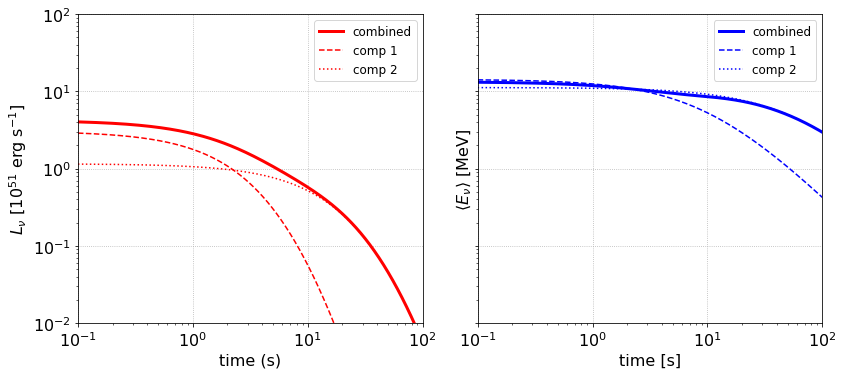

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12,5.5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.plot(t, Lnu/1e51, 'r-', lw=3, label='combined')
ax.plot(t, comp1.Lnu(t)/1e51, 'r--', label='comp 1')
ax.plot(t, comp2.Lnu(t)/1e51, 'r:', label='comp 2')
ax.set(xscale='log', xlabel='time (s)',
       xlim=(0.1, 100),
       yscale='log', ylabel=r'$L_{\nu}$ [$10^{51}$ erg s$^{-1}$]',
       ylim=(1e-2, 1e2))
ax.grid(ls=':')
ax.legend(fontsize=12)

ax = axes[1]
ax.plot(t, Enu_avg, 'b-', lw=3, label='combined')
ax.plot(t, comp1.Enu_avg(t), 'b--', label='comp 1')
ax.plot(t, comp2.Enu_avg(t), 'b:', label='comp 2')
ax.set(xscale='log', xlabel='time [s]',
       yscale='log', ylabel=r'$\langle E_{\nu}\rangle$ [MeV]')
ax.grid(ls=':')
ax.legend(fontsize=12);

## Numerical Solutions

Plot the numerical solutions shown in Y. Suwa et al., [ApJ **881**:139, 2019](https://arxiv.org/abs/1904.09996).

| Model 	| $M_\mathrm{PNS}$ [$M_\odot$] 	| $R_\mathrm{PNS}$ [km] 	|  $g$ 	| $\beta_1$ 	| $E_{\mathrm{tot},1}$ [$10^{52}$ erg] 	| $\beta_2$ 	| $E_{\mathrm{tot},1}$ [$10^{52}$ erg] 	|
|:-----:	|:----------------------------:	|:---------------------:	|:----:	|:---------:	|:------------------------------------:	|:---------:	|:------------------------------------:	|
|  147S 	|              1.5             	|           12          	| 0.04 	|     3     	|                  4.0                 	|     40    	|                  10                  	|
|  M1L  	|              1.3             	|           11          	| 0.04 	|     3     	|                  2.5                 	|     25    	|                  5.0                 	|
|  M1H  	|              1.3             	|           11          	| 0.04 	|     3     	|                  2.5                 	|     30    	|                  9.0                 	|
|  M2L  	|              2.3             	|           13          	|  0.1 	|     3     	|                  8.0                 	|     30    	|                  22                  	|
|  M2H  	|              2.3             	|           13          	|  0.1 	|     3     	|                  11                  	|     40    	|                  35                  	|

In [8]:
modelpars = [
    ['147S', 1.5, 12, 0.04, 3, 40., 4e52,   10e52],
    ['M1L',  1.3, 11, 0.04, 3, 25., 2.5e52,  5e52],
    ['M1H',  1.3, 11, 0.04, 3, 30., 2.5e52,  9e52],
    ['M2L',  2.3, 13, 0.1,  3, 30., 8e52,   22e52],
    ['M2H',  2.3, 13, 0.1,  3, 40., 11e52,  35e52]
]

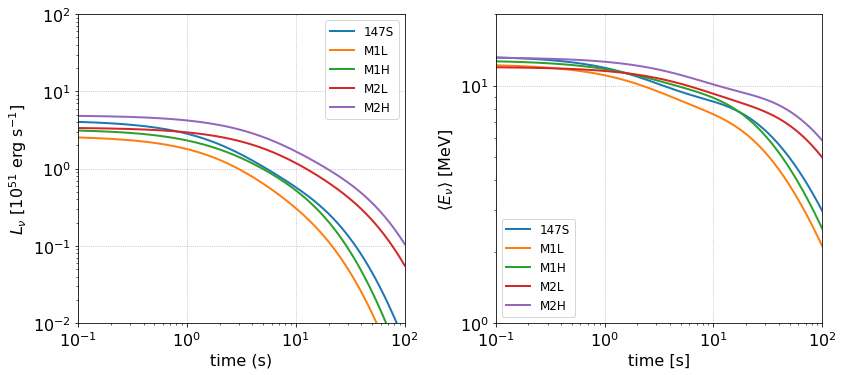

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,5.5), sharex=True, sharey=False, tight_layout=True)

for mpars in modelpars:
    name, pars = mpars[0], mpars[1:]
    model = CCSNAnalytic2Component(*pars)
    
    ax = axes[0]
    ax.plot(t, model.Lnu(t)/1e51, lw=2, label=name)

    ax = axes[1]
    ax.plot(t, model.Enu_avg(t), lw=2, label=name)

ax = axes[0]
ax.set(xscale='log', xlabel='time (s)',
       xlim=(0.1, 100),
       yscale='log', ylabel=r'$L_{\nu}$ [$10^{51}$ erg s$^{-1}$]',
       ylim=(1e-2, 1e2))
ax.grid(ls=':')
ax.legend(fontsize=12)

ax = axes[1]
ax.set(xscale='log', xlabel='time [s]',
       yscale='log', ylabel=r'$\langle E_{\nu}\rangle$ [MeV]',
       ylim=(1, 20))
ax.grid(ls=':')
ax.legend(fontsize=12);